## Setup

In [ ]:
%%writefile requirements.txt
numpy
pandas
matplotlib
seaborn
scikit-learn
gensim
optuna
torch
transformers
fasttext
ipywidgets

Overwriting requirements.txt


In [ ]:
!pip install -q -r requirements.txt --no-cache-dir --force-reinstall

In [ ]:
import pandas as pd
import numpy as np

## Load data

In [ ]:
toxicity_cols = [
    'toxicity',
    'obscene',
    'identity_attack',
    'insult',
    'threat',
    'sexual_explicit'
]

cols_to_load = toxicity_cols + ['created_date', 'comment_text', 'comment_text_tokenized_tab', 'toxicity_annotator_count']

In [ ]:
df = pd.read_csv('./data_tokenized.csv', usecols=cols_to_load, parse_dates=['created_date'], date_format='ISO8601')
df.head()

,toxicity,comment_text,obscene,identity_attack,insult,threat,created_date,sexual_explicit,toxicity_annotator_count,comment_text_tokenized_tab
0,0.000000,"This is so cool. It's like, 'would you want yo...",0.0,0.000000,0.00000,0.0,2015-09-29 10:50:41.987077+00:00,0.0,4,cool\tlike\twould\twant\tmother\tread\treally\...
1,0.000000,Thank you!! This would make my life a lot less...,0.0,0.000000,0.00000,0.0,2015-09-29 10:50:42.870083+00:00,0.0,4,thank\twould\tmake\tlife\tlot\tless\tanxiety\t...
2,0.000000,This is such an urgent design problem; kudos t...,0.0,0.000000,0.00000,0.0,2015-09-29 10:50:45.222647+00:00,0.0,4,urgent\tdesign\tproblem\tkudo\ttake\timpressive
3,0.000000,Is this something I'll be able to install on m...,0.0,0.000000,0.00000,0.0,2015-09-29 10:50:47.601894+00:00,0.0,4,something\table\tinstall\tsite\trelease
4,0.893617,haha you guys are a bunch of losers.,0.0,0.021277,0.87234,0.0,2015-09-29 10:50:48.488476+00:00,0.0,47,haha\tguy\tbunch\tloser


## Split data

In [ ]:
df = df.dropna(subset='comment_text').sort_values(by='toxicity_annotator_count', ascending=False).drop_duplicates(subset='comment_text', keep='first').reset_index(drop=True)
df = df.drop(['comment_text', 'toxicity_annotator_count'], axis=1)

df['comment_text_tokenized_tab'] = df['comment_text_tokenized_tab'].fillna('').astype('str')

df = df[df['created_date'] >= '2016-06-01'].reset_index(drop=True)

for col in toxicity_cols:
    df[col] = np.where(df[col] >= 0.4, 1, 0).astype('uint8')

df.head()

,toxicity,obscene,identity_attack,insult,threat,created_date,sexual_explicit,comment_text_tokenized_tab
0,1,1,0,0,0,2017-04-10 23:30:10.076014+00:00,1,stick\tdick\tanyone\t's\tbutt\tlaw
1,1,1,0,1,0,2017-06-08 18:24:06.236150+00:00,1,bet\tfat\tbitter\tlittle\tnerd\tass\twait\tday...
2,1,0,0,1,1,2017-05-23 18:10:27.505027+00:00,0,hope\tdie\ttoday\tworld\tmuch\twell\twithout\t...
3,1,0,0,0,1,2017-06-26 21:37:55.561744+00:00,0,let\tdie\tmaybe\tbuild\tconcentration\tcamp\tg...
4,1,0,0,1,1,2017-07-13 21:15:03.037890+00:00,0,shoot\tpermanent\tsolution\tcreature\twaste\ts...


In [ ]:
test_split_date = df['created_date'].quantile(0.8)
test_split_mask = (df['created_date'] >= test_split_date)

validation_split_date = df[~test_split_mask]['created_date'].quantile(0.8)
validation_split_mask = (df[~test_split_mask]['created_date'] >= validation_split_date)

text_col = 'comment_text_tokenized_tab'

X, y = df[text_col], df[toxicity_cols]

X_train, y_train, X_test, y_test = (df[text_col][~test_split_mask],
                                    df[toxicity_cols][~test_split_mask],
                                    df[text_col][test_split_mask],
                                    df[toxicity_cols][test_split_mask])

X_train, y_train, X_val, y_val = (X_train[~validation_split_mask],
                                  y_train[~validation_split_mask],
                                  X_train[validation_split_mask],
                                  y_train[validation_split_mask])

In [ ]:
len(X_train), len(X_val), len(X_test)

(1092918, 273230, 341537)

## Training

In [ ]:
import gensim

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc,
    roc_auc_score,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output, display
from ipywidgets import Output

from tqdm.notebook import tqdm
from collections import Counter
from functools import partial
import os

### Build vocabulary

In [ ]:
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

In [ ]:
vocab = {PAD_TOKEN: 0, UNK_TOKEN: 1}

In [ ]:
counter = Counter(token for token_list in X_train.str.split('\t').values for token in token_list)

In [ ]:
counter.most_common(10)

[('would', 221146),
 ("'s", 208110),
 ('get', 192360),
 ('people', 191266),
 ('one', 178006),
 ('like', 163329),
 ('go', 160541),
 ('trump', 157986),
 ('make', 154198),
 ('say', 144365)]

In [ ]:
MIN_FREQ = 4

In [ ]:
for token, freq in counter.most_common():
    if freq >= MIN_FREQ:
        vocab[token] = len(vocab)

In [ ]:
len(vocab)

72599

### Load pretrained embeddings and build embeddding matrix

In [ ]:
wv = gensim.models.KeyedVectors.load_word2vec_format('./word2vec-google-news-300.gz', binary=True)

In [ ]:
len(wv), wv.vector_size

(3000000, 300)

In [ ]:
emb_matrix = torch.stack([torch.FloatTensor(np.copy(wv[token])) if token in wv else torch.randn(wv.vector_size, dtype=torch.float32)
                          for token in vocab.keys()])

In [ ]:
emb_matrix.shape, emb_matrix.dtype

(torch.Size([72599, 300]), torch.float32)

### Describe Dataset class and build DataLoader

In [ ]:
class SeqDataset(Dataset):
    def __init__(self, corpus, labels, vocab, max_seq_length=500):
        assert len(corpus) == len(labels)
        self.corpus = corpus
        self.labels = labels
        self.vocab = vocab
        self.max_seq_length = max_seq_length

        self.unk_value = vocab[UNK_TOKEN]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        seq = torch.LongTensor([self.vocab.get(token, self.unk_value)
                                for token in self.corpus[idx].split('\t')[:self.max_seq_length]])
        label = torch.LongTensor([self.labels[idx]])

        return seq, label

In [ ]:
train_dataset = SeqDataset(X_train.values, y_train['toxicity'].values, vocab)

In [ ]:
train_dataset[0]

(tensor([ 800, 3670,  133,    3, 2895,   52]), tensor([1]))

In [ ]:
def collate_fn(batch, padding_value):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=padding_value)

    return texts_padded, torch.cat(labels)

In [ ]:
next(iter(DataLoader(
    dataset=train_dataset,
    collate_fn=partial(collate_fn, padding_value=vocab[PAD_TOKEN]),
    batch_size=3,
    shuffle=False
)))

(tensor([[  800,  3670,   133,     3,  2895,    52,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0],
         [  817,  1795,  3871,   135, 12677,  2995,   319,    54,    70,    29,
           1159,    82,     4,  1250,  2160,   806, 17930],
         [  162,   432,   228,    56,    33,    13,   114,  8342,     7,     0,
              0,     0,     0,     0,     0,     0,     0]]),
 tensor([1, 1, 1]))

In [ ]:
train_dataset = SeqDataset(X_train.values, y_train['toxicity'].values, vocab)
val_dataset = SeqDataset(X_val.values, y_val['toxicity'].values, vocab)
test_dataset = SeqDataset(X_test.values, y_test['toxicity'].values, vocab)

train_loader = DataLoader(
    dataset=train_dataset,
    collate_fn=partial(collate_fn, padding_value=vocab[PAD_TOKEN]),
    batch_size=2048,
    shuffle=True,
    num_workers=4,
)

val_loader = DataLoader(
    dataset=val_dataset,
    collate_fn=partial(collate_fn, padding_value=vocab[PAD_TOKEN]),
    batch_size=2048,
    shuffle=False,
    num_workers=4,
)

test_loader = DataLoader(
    dataset=test_dataset,
    collate_fn=partial(collate_fn, padding_value=vocab[PAD_TOKEN]),
    batch_size=2048,
    shuffle=False,
    num_workers=4,
)

### Train loop and evaluation setup

In [ ]:
def plot_train_results(results, train_loader):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    val_loss_points = np.arange(1, len(results['val_loss_by_epoch'])+1)*len(train_loader)
    ax[0].plot(results['train_loss_by_step'], color='tab:blue', label='Train loss')
    ax[0].plot(val_loss_points, results['val_loss_by_epoch'], color='tab:orange', label='Val loss', marker='o')
    ax[0].set_title('Loss trace')
    ax[0].set_xlabel('Optimizer step')
    ax[0].set_ylabel('Loss')
    ax[0].grid()

    ax01 = ax[0].twinx()
    ax01.plot(results['lr_by_step'], label='LR', color='tab:green', ls='--')
    ax01.set_ylabel('Learning rate')

    lines1, labels1 = ax[0].get_legend_handles_labels()
    lines2, labels2 = ax01.get_legend_handles_labels()
    ax[0].legend(lines1 + lines2, labels1 + labels2, loc='best')

    val_metric_points = np.arange(1, len(results['val_metric_by_epoch'])+1)*len(train_loader)
    ax[1].plot(results['train_metric_by_step'], color='tab:blue', label='Train metric')
    ax[1].plot(val_metric_points, results['val_metric_by_epoch'], color='tab:orange', label='Val metric', marker='o')
    ax[1].set_title('Metric trace')
    ax[1].set_xlabel('Optimizer step')
    ax[1].grid()
    ax[1].legend(loc='best')
    ax[1].set_ylabel('Metric')

    plt.tight_layout()
    plt.show()

In [ ]:
def train_nn(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    epochs,
    model_name,
    scheduler=None,
    save_dir="best_models",
    patience=5,
):

    results = {
        'train_loss_by_step': [],
        'train_metric_by_step': [],
        'train_loss_by_epoch': [],
        'train_metric_by_epoch': [],
        'val_loss_by_epoch': [],
        'val_metric_by_epoch': [],
        'val_best_loss': np.inf,
        'lr_by_step': []
    }


    os.makedirs(save_dir, exist_ok=True)
    epochs_no_improve = 0

    plot_widget = Output()
    display(plot_widget)

    epochs_pbar = tqdm(list(range(1, epochs+1)), desc="Epochs", leave=False)
    for epoch in epochs_pbar:

        model.train()
        train_loss_epoch = []
        train_labels_epoch = []
        train_preds_epoch = []

        train_pbar = tqdm(train_loader, desc="Training", leave=False)
        for batch_num, (data, labels) in enumerate(train_pbar, 1):
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)
            loss = criterion(outputs, labels.to(torch.float))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            labels_step = labels.cpu().numpy()
            preds_step = (outputs > 0.5).to(torch.long).cpu().numpy()

            train_loss_epoch.append(loss.item())
            train_labels_epoch.extend(labels_step)
            train_preds_epoch.extend(preds_step)

            metric_step = f1_score(labels_step, preds_step, average='binary')

            results['train_loss_by_step'].append(loss.item())
            results['train_metric_by_step'].append(metric_step)

            train_pbar.set_postfix({"loss": loss.item(), "metric": metric_step})

            if scheduler is not None:
                results['lr_by_step'].append(scheduler.get_last_lr())


        results['train_loss_by_epoch'].append(np.mean(train_loss_epoch))
        results['train_metric_by_epoch'].append(f1_score(train_labels_epoch, train_preds_epoch, average='binary'))


        model.eval()
        val_loss_epoch = []
        val_labels_epoch = []
        val_preds_epoch = []

        with torch.no_grad():

            val_pbar = tqdm(val_loader, desc="Validating", leave=False)
            for batch_num, (data, labels) in enumerate(val_pbar, 1):
                data, labels = data.to(device), labels.to(device)

                outputs = model(data)
                loss = criterion(outputs, labels.to(torch.float))

                labels_step = labels.cpu().numpy()
                preds_step = (outputs > 0.5).to(torch.long).cpu().numpy()

                val_loss_epoch.append(loss.item())
                val_labels_epoch.extend(labels_step)
                val_preds_epoch.extend(preds_step)

                val_pbar.set_postfix({"loss": loss.item()})

        results['val_loss_by_epoch'].append(np.mean(val_loss_epoch))
        results['val_metric_by_epoch'].append(f1_score(val_labels_epoch, val_preds_epoch, average='binary'))

        if scheduler is not None:
            scheduler.step(results['val_loss_by_epoch'][-1])

        tqdm.write(
            f"Epoch {epoch}:\n"
            f"Train average loss: {results['train_loss_by_epoch'][-1]:.3f}, "
            f"Train metric: {results['train_metric_by_epoch'][-1]:.3f}\n"
            f"Val average loss: {results['val_loss_by_epoch'][-1]:.3f}, "
            f"Val metric: {results['val_metric_by_epoch'][-1]:.3f}"
        )

        with plot_widget:
            clear_output(wait=True)
            plot_train_results(results, train_loader)

        if results['val_loss_by_epoch'][-1] < results['val_best_loss']:
            epochs_no_improve = 0
            tqdm.write("Best loss updated, saving the model")
            results['val_best_loss'] = results['val_loss_by_epoch'][-1]
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'loss': results['val_best_loss']
                }, os.path.join(save_dir, f'best_{model_name}.pth')
            )
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                tqdm.write("Early stopping triggered")
                break

    return results

In [ ]:
def plot_metrics_single(
    model,
    model_name,
    label_name,
    loader_left,
    loader_right,
    left_set_name,
    right_set_name
):
    y_pred_dict = {
        left_set_name: [],
        f'{left_set_name}_proba': [],
        right_set_name: [],
        f'{right_set_name}_proba': []
    }

    y_true_dict = {
        left_set_name: [],
        right_set_name: []
    }

    model.eval()
    with torch.no_grad():

        left_pbar = tqdm(loader_left, desc="Loading left set", leave=False)
        for batch_num, (data, labels) in enumerate(left_pbar, 1):
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)

            y_true_dict[left_set_name].extend(labels.cpu().numpy())
            y_pred_dict[f'{left_set_name}_proba'].extend(outputs.cpu().numpy())
            y_pred_dict[left_set_name].extend((outputs > 0.5).to(torch.long).cpu().numpy())


        right_pbar = tqdm(loader_right, desc="Loading right set", leave=False)
        for batch_num, (data, labels) in enumerate(right_pbar, 1):
            data, labels = data.to(device), labels.to(device)

            outputs = model(data)

            y_true_dict[right_set_name].extend(labels.cpu().numpy())
            y_pred_dict[f'{right_set_name}_proba'].extend(outputs.cpu().numpy())
            y_pred_dict[right_set_name].extend((outputs > 0.5).to(torch.long).cpu().numpy())

    def plot_metrics_table(y_true, y_pred, set_name, ax):
        tbl = pd.DataFrame.from_dict({'precision': precision_score(y_true, y_pred, zero_division=np.nan),
                                      'recall': recall_score(y_true, y_pred, zero_division=np.nan),
                                      'f1-score': f1_score(y_true, y_pred, zero_division=np.nan)}, orient='index').T
        ax.table(cellText=tbl.values.round(2), colLabels=tbl.columns.values, loc='center')
        ax.axis('off')
        ax.set_title(f'{set_name}', loc='left')

    def plot_confusion_matrix(y_true, y_pred, ax):
        sns.heatmap(confusion_matrix(y_true, y_pred, normalize='all'), annot=True, ax=ax, fmt='.1%', cmap='Blues')
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
        ax.set_title('Confusion Matrix', loc='left', fontsize='small')

    def plot_roc_curve(y_true, y_pred_proba, ax):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'ROC curve: AUC={auc(fpr, tpr):.2f}', loc='left', fontsize='small')
        ax.set_ylim(bottom=0, top=1)
        ax.set_xlim(left=0, right=1)
        ax.grid()

    def plot_pr_curve(y_true, y_pred_proba, ax):
        prec, rec, _ = precision_recall_curve(y_true, y_pred_proba)
        sorted_index = np.argsort(rec)
        prec = prec[sorted_index]
        rec = rec[sorted_index]
        ax.plot(rec, prec)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall curve: AUC={auc(rec, prec):.2f}', loc='left', fontsize='small')
        ax.set_ylim(bottom=0, top=1)
        ax.set_xlim(left=0, right=1)
        ax.grid()

    fig = plt.figure(figsize=(8, 8), layout='constrained')
    gs = fig.add_gridspec(4, 2, height_ratios=[0.05, 0.15, 0.35, 0.35])
    nrows, ncols = gs.get_geometry()
    ax = [[fig.add_subplot(gs[row, col]) for col in range(ncols)] for row in range(nrows)]

    for colnum, set_name in enumerate([left_set_name, right_set_name]):
        plot_metrics_table(y_true_dict[set_name], y_pred_dict[set_name], set_name, ax[0][colnum])
        plot_confusion_matrix(y_true_dict[set_name], y_pred_dict[set_name], ax[1][colnum])
        plot_roc_curve(y_true_dict[set_name], y_pred_dict[f'{set_name}_proba'], ax[2][colnum])
        plot_pr_curve(y_true_dict[set_name], y_pred_dict[f'{set_name}_proba'], ax[3][colnum])

    fig.suptitle(f'Classification metrics for {model_name}, "{label_name}" label')

### Conv-based model

In [ ]:
class CNNClassifier(nn.Module):

    def __init__(
        self,
        embedding_matrix=None,
        vocab_size=None,
        embedding_dim=None,
        kernel_sizes=[3, 4, 5],
        num_filters=100
    ):
        super().__init__()

        assert embedding_matrix is not None or (vocab_size is not None and embedding_dim is not None)

        if embedding_matrix is not None:
            self.emb = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
            embedding_dim = embedding_matrix.shape[1]
        else:
            self.emb = nn.Embedding(vocab_size, embedding_dim)

        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, ks) for ks in kernel_sizes
        ])

        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.emb(x)
        x = x.permute(0, 2, 1)

        features = [F.relu(conv(x)) for conv in self.convs]
        features = [F.max_pool1d(f, f.shape[-1]).squeeze(-1) for f in features]

        out = torch.cat(features, dim=1)
        out = self.sigmoid(self.fc(self.dropout(out)))

        return out.squeeze(1)

In [ ]:
CNNClassifier(vocab_size=len(vocab), embedding_dim=wv.vector_size)(next(iter(DataLoader(
    dataset=train_dataset,
    collate_fn=partial(collate_fn, padding_value=vocab[PAD_TOKEN]),
    batch_size=3,
    shuffle=False
)))[0])

tensor([0.5592, 0.5664, 0.5083], grad_fn=<SqueezeBackward1>)

In [ ]:
CNNClassifier(emb_matrix)(next(iter(DataLoader(
    dataset=train_dataset,
    collate_fn=partial(collate_fn, padding_value=vocab[PAD_TOKEN]),
    batch_size=3,
    shuffle=False
)))[0])

tensor([0.4759, 0.5011, 0.4918], grad_fn=<SqueezeBackward1>)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
model = CNNClassifier(emb_matrix).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
res = train_nn(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=12,
    model_name='cnn'
)

Output()

Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 1:
Train average loss: 0.209, Train metric: 0.542
Val average loss: 0.184, Val metric: 0.629
Best loss updated, saving the model


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 2:
Train average loss: 0.170, Train metric: 0.641
Val average loss: 0.183, Val metric: 0.622
Best loss updated, saving the model


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 3:
Train average loss: 0.157, Train metric: 0.674
Val average loss: 0.187, Val metric: 0.633


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 4:
Train average loss: 0.144, Train metric: 0.710
Val average loss: 0.196, Val metric: 0.611


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 5:
Train average loss: 0.129, Train metric: 0.747
Val average loss: 0.209, Val metric: 0.616


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 6:
Train average loss: 0.113, Train metric: 0.784
Val average loss: 0.225, Val metric: 0.605


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 7:
Train average loss: 0.090, Train metric: 0.837
Val average loss: 0.254, Val metric: 0.607
Early stopping triggered


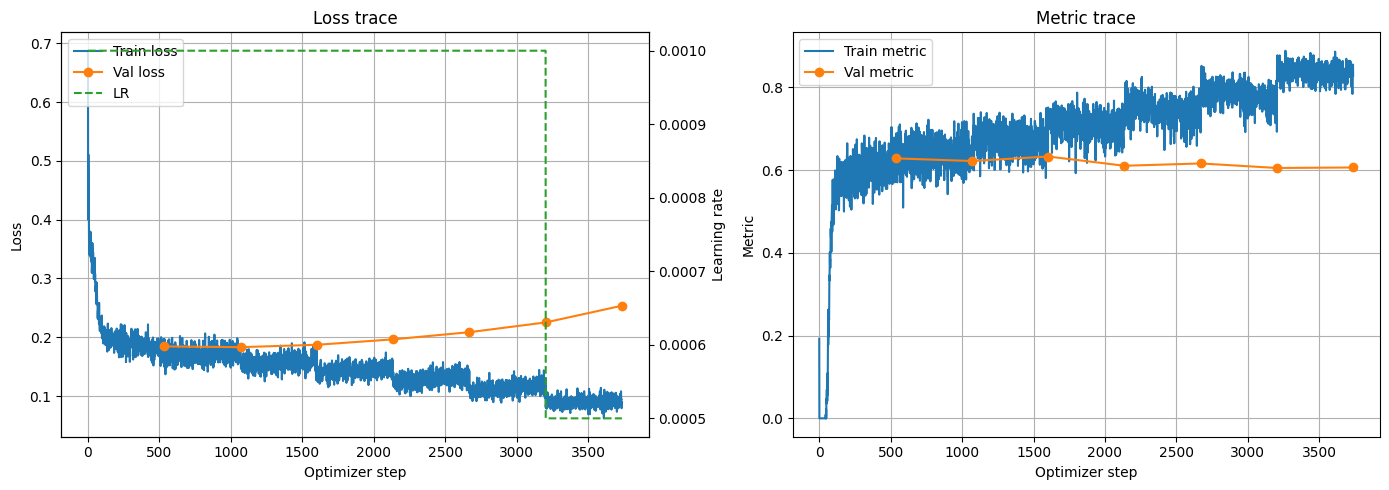

In [ ]:
plot_train_results(res, train_loader)

In [ ]:
checkpoint = torch.load('best_models/best_cnn.pth', weights_only=False)
model = CNNClassifier(vocab_size=len(vocab), embedding_dim=wv.vector_size)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Loading left set:   0%|          | 0/534 [00:00<?, ?it/s]

Loading right set:   0%|          | 0/167 [00:00<?, ?it/s]

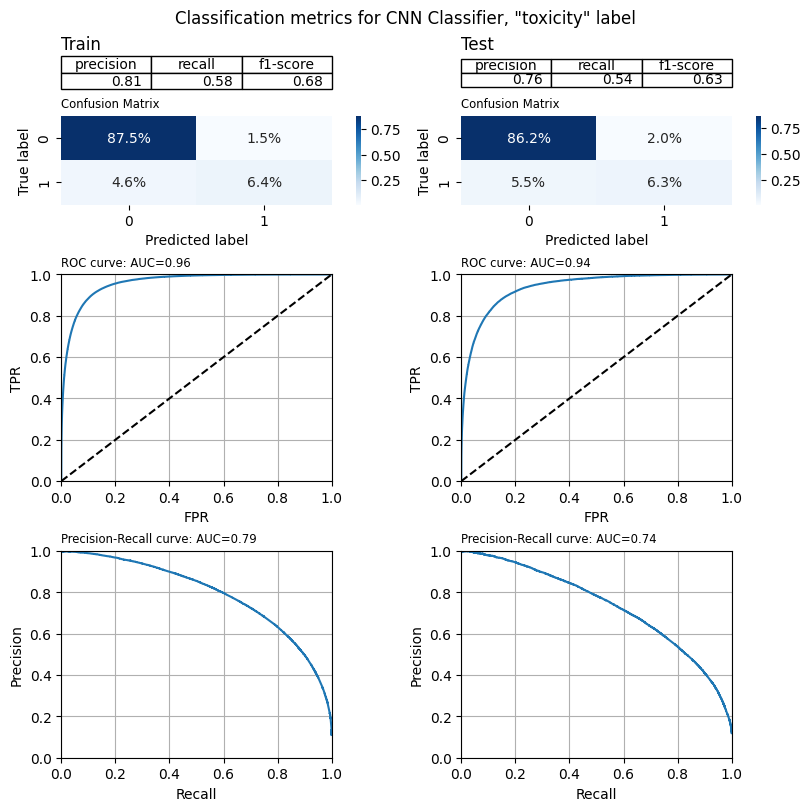

In [ ]:
plot_metrics_single(
    model=model,
    model_name='CNN Classifier',
    label_name='toxicity',
    loader_left=train_loader,
    loader_right=test_loader,
    left_set_name='Train',
    right_set_name='Test'
)

### GRU-based model

In [ ]:
class GRUClassifier(nn.Module):
    def __init__(
        self,
        embedding_matrix=None,
        vocab_size=None,
        embedding_dim=None,
        hidden_dim=128
    ):
        super().__init__()

        assert embedding_matrix is not None or (vocab_size is not None and embedding_dim is not None)

        if embedding_matrix is not None:
            self.emb = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
            embedding_dim = embedding_matrix.shape[1]
        else:
            self.emb = nn.Embedding(vocab_size, embedding_dim)

        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, h_n = self.gru(self.emb(x))
        out = self.sigmoid(self.fc(self.dropout(h_n[-1])))

        return out.squeeze(1)

In [ ]:
GRUClassifier(vocab_size=len(vocab), embedding_dim=wv.vector_size)(next(iter(DataLoader(
    dataset=train_dataset,
    collate_fn=partial(collate_fn, padding_value=vocab[PAD_TOKEN]),
    batch_size=3,
    shuffle=False
)))[0])

tensor([0.5031, 0.6036, 0.5432], grad_fn=<SqueezeBackward1>)

In [ ]:
GRUClassifier(emb_matrix)(next(iter(DataLoader(
    dataset=train_dataset,
    collate_fn=partial(collate_fn, padding_value=vocab[PAD_TOKEN]),
    batch_size=3,
    shuffle=False
)))[0])

tensor([0.6417, 0.5154, 0.7083], grad_fn=<SqueezeBackward1>)

In [ ]:
emb_matrix = torch.stack([torch.FloatTensor(np.copy(wv[token])) if token in wv else torch.randn(wv.vector_size, dtype=torch.float32)
                          for token in vocab.keys()])

In [ ]:
model = GRUClassifier(emb_matrix).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [ ]:
res = train_nn(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=12,
    model_name='gru'
)

Output()

Epochs:   0%|          | 0/12 [00:00<?, ?it/s]

Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 1:
Train average loss: 0.234, Train metric: 0.480
Val average loss: 0.179, Val metric: 0.622
Best loss updated, saving the model


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 2:
Train average loss: 0.162, Train metric: 0.657
Val average loss: 0.176, Val metric: 0.634
Best loss updated, saving the model


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 3:
Train average loss: 0.150, Train metric: 0.686
Val average loss: 0.179, Val metric: 0.650


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 4:
Train average loss: 0.135, Train metric: 0.723
Val average loss: 0.192, Val metric: 0.629


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 5:
Train average loss: 0.116, Train metric: 0.771
Val average loss: 0.216, Val metric: 0.627


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 6:
Train average loss: 0.095, Train metric: 0.819
Val average loss: 0.243, Val metric: 0.609


Training:   0%|          | 0/534 [00:00<?, ?it/s]

Validating:   0%|          | 0/134 [00:00<?, ?it/s]

Epoch 7:
Train average loss: 0.068, Train metric: 0.877
Val average loss: 0.306, Val metric: 0.600
Early stopping triggered


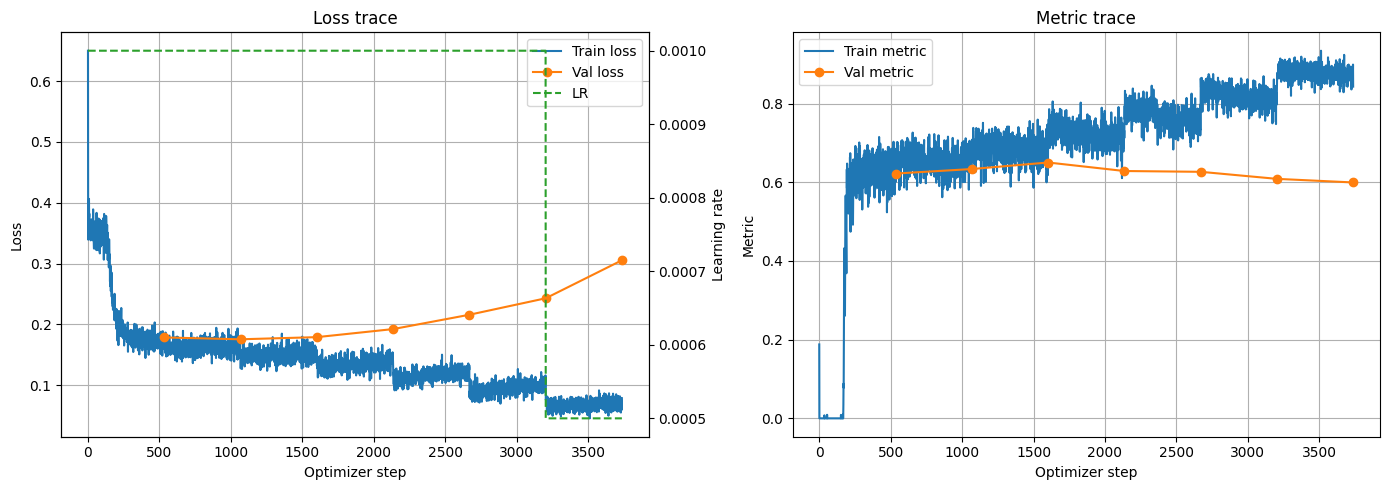

In [ ]:
plot_train_results(res, train_loader)

In [ ]:
checkpoint = torch.load('best_models/best_gru.pth', weights_only=False)
model = GRUClassifier(vocab_size=len(vocab), embedding_dim=wv.vector_size)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Loading left set:   0%|          | 0/534 [00:00<?, ?it/s]

Loading right set:   0%|          | 0/167 [00:00<?, ?it/s]

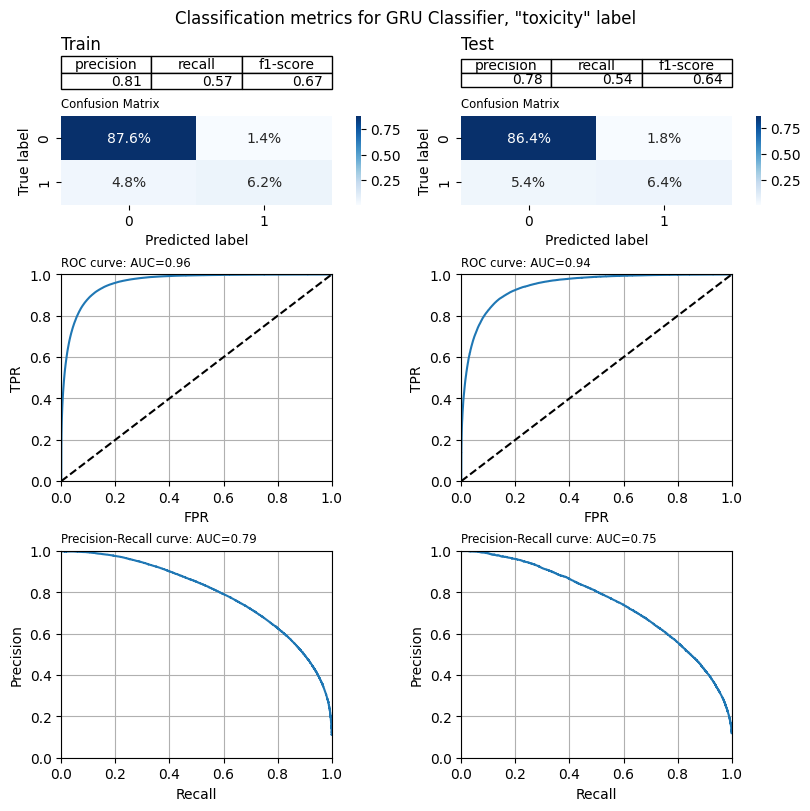

In [ ]:
plot_metrics_single(
    model=model,
    model_name='GRU Classifier',
    label_name='toxicity',
    loader_left=train_loader,
    loader_right=test_loader,
    left_set_name='Train',
    right_set_name='Test'
)